<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-библиотек" data-toc-modified-id="Загрузка-данных-и-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и библиотек</a></span></li><li><span><a href="#Предварительная-обработка-данных" data-toc-modified-id="Предварительная-обработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предварительная обработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-и-создание-признаков" data-toc-modified-id="Ресемплирование-и-создание-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование и создание признаков</a></span></li><li><span><a href="#Создание-выборок" data-toc-modified-id="Создание-выборок-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание выборок</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Выбор-наилучшей-модели" data-toc-modified-id="Выбор-наилучшей-модели-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выбор наилучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

В рамках данного задания необходимо построить модель для прогнозирования количества заказов такси в разное время суток. Для повышения точности прогнозирования будет проведена настройка гиперпараметров. Критерием достижения поставленной цели будет являться значение метрики RMSE не более 48. Проект будет разделен на несколько этапов:
1. Загрузка и предварительная обработка данных
2. Подбор и оптимизация модели на обучающей выборке
3. Проверка модели на тестовой выборке
4. Выводы

### Загрузка данных и библиотек

Загрузим библиотеки

In [477]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Загрузка и первичное ознакомление с данными

In [478]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [479]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [480]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Файл содержит порядка 26 тысяч записей разбитых на десятиминутные интервалы. Проведем их предварительную обработку

### Предварительная обработка данных

Проверим на пропущенные значения

In [481]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропущенные значения не обнаружены. Проверим соблюдение хронологического порядка 

In [482]:
data.index.is_monotonic

True

## Анализ

### Ресемплирование и создание признаков

Проведем ресемплирование по одному часу

In [483]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [484]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Представим данные в графическом виде 

<AxesSubplot:xlabel='day'>

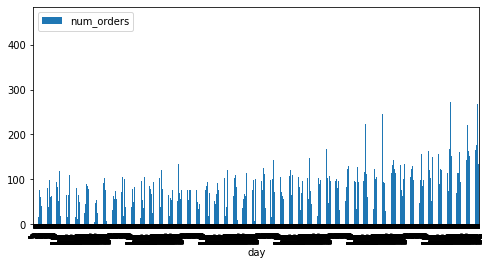

In [485]:
data['day'] = data.index.day
data.plot(kind='bar', x='day', y='num_orders', figsize=(8,4))

Визуальный анализ графика позволяет сделать вывод о наличии трендов и сезонности. Проведем декомпозицию данных

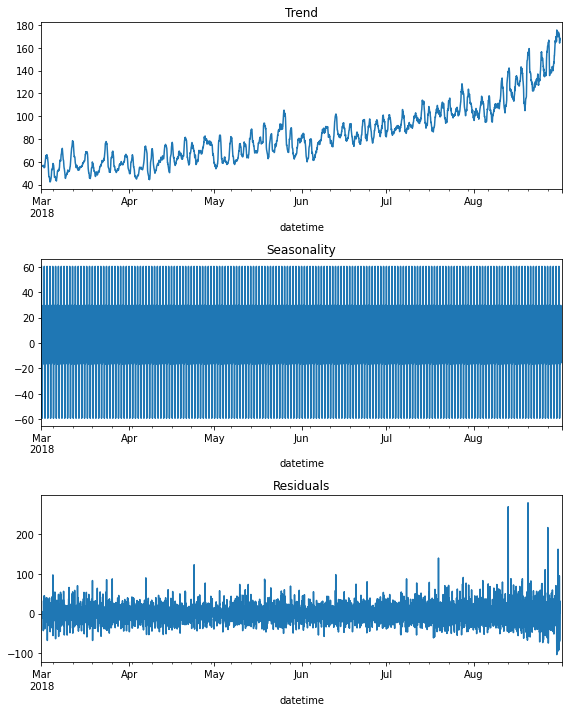

In [486]:
data = data.drop('day', axis=1)
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В целом можно отметить повышательный тренд. Месячная сезонность не наблюдаема поскольку данные представлены только за 6 месяцев. Остатки распределены случайно. Дополнительно проанализируем данные на наличие внутринедельной и внутрисуточной сезонности

Внутринедельная сезонность. Для наглядности ограничим раcсматриваемый период мартом

In [487]:
data_by_day = data['2018-03':'2018-03']
data_by_day = data_by_day.resample('1D').sum()
data_by_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


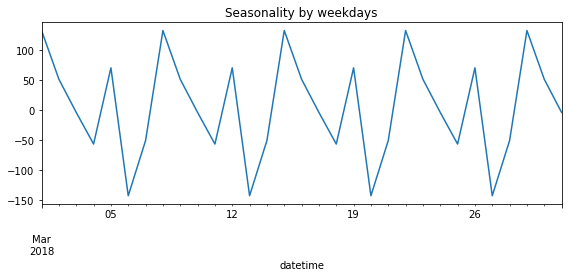

In [488]:
decomposed = seasonal_decompose(data_by_day)
plt.figure(figsize=(8,10))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality by weekdays')
plt.tight_layout()

График позволяет сделать вывод о наличии внутринедельной сезонности. Наименьшее количество заказов приходится на вторник, а наибольшее - на четверг. Проанализируем внутрисуточную сезонность. Для наглядности ограничим рассматриваемый период тремя днями

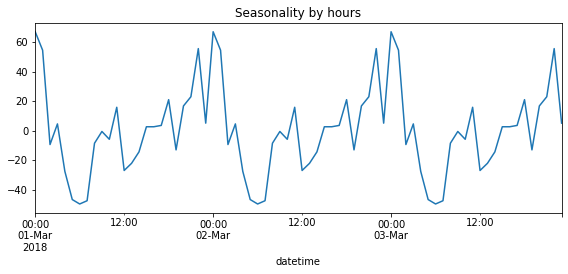

In [489]:
data_by_hour= data['2018-03-01':'2018-03-03']
decomposed = seasonal_decompose(data_by_hour)
plt.figure(figsize=(8,10))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality by hours')
plt.tight_layout()

График позволяет сделать вывод о наличии внутрисуточной сезонность. Минимум спроса приходится на ранние утренние часы, потом резко возрастате к полудню, немного снижается в послеобеденное время, возрастает в вечерние часы до полуночи и далее резко снижается к минимуму раннего утра

Данные представлены за период с марта по август 2018 года. Соответственно, в качестве временных признаков можно использовать день недели и час. Создадим через функцию временные признаки, а также отстающие признаки и скользящее среднее

In [490]:
def make_features(data, max_lag, rolling_mean_size):
    data['weekday'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag+1):
        data['lag{}'.format(lag)] = data['num_orders'].shift(lag)
    for rolling_mean in range (1, rolling_mean_size+1):    
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

Создадим ячейку для задания гиперпараметров. Изменяя ее значения ниже мы найдем наилменьшее значение RMSE

In [491]:
make_features(data, 300, 300)

### Создание выборок

Разделим выборку на обучающую, валидационную и тестовую. По условиям задачи тестовая должна составлять 10% общей. Валидационную установим в стандартном размере - 20% от общей. Удалим строки со значениями NaN

In [492]:
train, test = train_test_split(data, shuffle=False, test_size=0.3)
valid, test = train_test_split(test, shuffle=False, test_size=1/3)
train = train.dropna()

Выделим признаки и целевой признак

In [493]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение

По условиям задачи необходимо попробовать несколько моделей с разными гиперпараметрами. В нашем случае это будет линейная регрессия и дерево решений с программным подбором оптимальной глубины

### Линейная регрессия

In [494]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [495]:
predictions_lin = model.predict(features_valid)
print("RMSE обучающей выборки:", mean_squared_error(target_valid, predictions_lin)**.5)

RMSE обучающей выборки: 26.63620815367672


### Дерево решений

In [496]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predictions_tree = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_tree)**.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
print("Наименьший RMSE обучающей выборки:", best_result, 'при глубине дерева', best_depth)

Наименьший RMSE обучающей выборки: 31.806020140289686 при глубине дерева 5


### Выбор наилучшей модели

Изменяя значение в ячейке в разделе 2.1 подберем параметры обеспечивающие наименьшее значение RMSE. Результаты обобщим в таблице ниже

In [497]:
headings = ['Отст. признак', 'Скользящее среднее', 'RMSE, LR', 'RMSE, DT', 'Best depth for DT']
figures = [[1,1,41,40,9], [3,3,41,39,10], [10,10,40,37,8], [30,30,32,36,5], [100,100,28,33,6], [300,300,26,31,5]]
summary = pd.DataFrame(data=figures, columns=headings)
print(summary)

   Отст. признак  Скользящее среднее  RMSE, LR  RMSE, DT  Best depth for DT
0              1                   1        41        40                  9
1              3                   3        41        39                 10
2             10                  10        40        37                  8
3             30                  30        32        36                  5
4            100                 100        28        33                  6
5            300                 300        26        31                  5


Наибольшая точность прогнозирования на валидационной выборке достигается при использовании линейной регресси со значениями отстающего признака и скользящего среднего в 300. Проверим полученные результаты на тестовой выборке

## Тестирование

In [498]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, predictions)**.5)

RMSE тестовой выборки: 35.95070647463476


На тестовой выборке показатель RMSE с выбранными гиперпараметрами 300,300 составляет 35, то есть на четверть ниже целевого показателя. Модель может быть использована для прогнозирования количества заказов в такси

Заключение: целью данной работы являлась разработка модели для прогнозирования заказов такси на ближайший час. Необходимая точность предсказания измерялась показателем RMSE который не мог превышать 48. Для разработки модели была проведена обработка исходных данных, которая включалаа в себя создание дополнительных признаков. В дальнейшем к обработанным данным применялись модели линейной регрессии и дерева решений с перебором гиперпараметров для достижения необходимой точности прогнозирования. Гиперпараметры признанные наилучшими были применены к тестовой выборке. На тестовой выборке показатель RMSE составил 35. Модель линейной регрессии со значениями отстающего признака и скользящего среднего в 300 может быть рекомендована к использованию